In [1]:
import numpy as np
import pandas as pd

In [2]:
from random import shuffle

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [80]:
train_dataset = pd.read_excel("train3.xlsx")
test_dataset = pd.read_excel("recog3.xlsx")

Подготовим хранилища для результатов

In [81]:
train_dataset.__len__()

762

Предполагается, что у нас дан маркер таргета

In [82]:
target_col = "im"

In [83]:
train_target = np.array(train_dataset[target_col])
test_target = np.array(test_dataset[target_col])

In [84]:
train_target.__len__()

762

Так же предполагается, что я уже знаю, какой из параметров излишний

In [85]:
train_dataset.drop(columns = ['sys', target_col], inplace = True)
test_dataset.drop(columns = ['sys', target_col], inplace = True)

In [86]:
train_dataset.head(2)

,noma,ecg_id,MB0,MB1,MB2,MSEP,MSRP,MDP,MRR,MdSEP,...,msh22,msh23,msh24,msh25,msh26,msh27,msh28,msh29,msh30,msh31
0,61,46522,254,179,349,292,378,545,720,716,...,6.660123,5.549093,6.618528,5.510096,6.582642,5.501579,6.556057,5.493603,6.540355,5.468881
1,90,46886,197,144,303,224,382,488,790,788,...,6.726418,5.660824,6.682837,5.641838,6.650321,5.628031,6.628800,5.622539,6.617181,5.617567


Базовая модель для обнаружения лучших объектов - catboost

In [11]:
from catboost import CatBoostClassifier

In [12]:
model = CatBoostClassifier(logging_level = "Silent")

Обнаружение лучших признаков


In [13]:
from sklearn.model_selection import KFold

In [14]:
folds = KFold(n_splits = 4, shuffle = True)

In [15]:
data = pd.DataFrame.copy(train_dataset)

In [16]:
values = []

In [17]:
columns = data.columns

In [18]:
associated_values = np.zeros(columns.__len__())

In [19]:
associated_values.__len__()

87

In [20]:
for i in range(100):
    
    model = CatBoostClassifier(logging_level = 'Silent')
    
    cv = [[], [], [], []]
    cv_true = []
    
    for enum, indixes in enumerate(folds.split(data)):

        train_index = indixes[0]
        test_index = indixes[1]


        train = pd.DataFrame.copy(data.loc[train_index])
        test = pd.DataFrame.copy(data.loc[test_index])

        train_targ = train_target[train_index]
        test_targ = train_target[test_index]
        
        model.fit(train, train_targ)
        
        preds = model.predict_proba(test)[:, 1]
        
        cv_true.append(roc_auc_score(test_targ, preds))
        
        
        for column in columns:

            hold = np.array(test[column])

            res = np.copy(hold)

            shuffle(res)

            test[column] = res

            preds_shuffle = model.predict_proba(test)[:, 1]

            cv[enum].append(roc_auc_score(test_targ, preds_shuffle))

            test[column] = hold
            
    # тут получаем cv_true - набор результатов в исходном виде
    # cv - 4 набора результатов по каждой колонке
    
    norm_results = np.array(cv_true).reshape(-1, 1)
    new_results = np.array(cv)
    
    associated_values += (new_results - norm_results).sum(axis = 0)

In [21]:
associated_values

array([-1.27412835e+00, -1.32547258e+00, -1.52956147e-01, -2.69273411e-01,
       -5.74245228e-03, -1.18323989e-01, -6.57152576e-01, -1.06268622e-01,
       -1.19266946e-01, -2.01070242e-01, -1.77808065e-01, -6.73621974e-02,
        4.15244333e-02,  5.39202640e-02,  3.94153598e-02,  6.49896392e-02,
       -1.07124807e-01,  2.49797984e-02, -1.40619813e-02, -9.15966907e-03,
       -5.90271185e-01, -2.91476845e-02, -9.09072246e-01, -4.81074517e+00,
       -4.96013942e+00, -8.72839120e-02, -2.95778095e+00, -2.81379905e-01,
       -4.13342164e-01, -1.07461162e-01, -7.97498163e-02, -2.45727069e-01,
       -8.55473754e-02, -1.07440948e-01, -1.01541980e-01, -4.13134996e-02,
       -3.96849927e-02, -5.25655701e-03,  2.62744138e-02, -8.24252391e-03,
       -4.25596412e-02, -2.93057511e-02, -1.99387573e-04, -4.01999170e-02,
       -5.75892922e-02, -7.56237425e-02, -6.41421687e-02, -7.83231435e-02,
       -6.83661540e-02, -9.52839084e-02, -7.72240411e-02, -6.86219523e-02,
       -7.80576935e-02, -

These are values of total accuracy change. let's revert them and crop by zero

In [22]:
val_decr = -1 * associated_values

In [23]:
good_order = np.argwhere(val_decr > 0.05).T[0]

In [24]:
kept_columns = columns[good_order]

In [25]:
kept_values = val_decr[good_order]

In [26]:
order_inds = np.argsort(kept_values)

In [27]:
order_columns = kept_columns[order_inds][::-1]
order_values = kept_values[order_inds][::-1]

In [28]:
new_val = np.log(order_values)

In [29]:
new_val -= new_val[-1]

In [30]:
new_val /= new_val[0]

In [31]:
model = CatBoostClassifier()

model.fit(train_dataset, train_target)

catboost_importance = model.get_feature_importance()

catboost_sorted = np.argsort(catboost_importance)[::-1]

catboost_columns = train_dataset.columns[catboost_sorted]

catboost_values = catboost_importance[catboost_sorted]

catboost_values = catboost_values * 100 / catboost_values.max()

Learning rate set to 0.013652
0:	learn: 0.6755047	total: 9.08ms	remaining: 9.07s
1:	learn: 0.6633947	total: 16.4ms	remaining: 8.18s
2:	learn: 0.6500839	total: 21.4ms	remaining: 7.12s
3:	learn: 0.6376672	total: 26.8ms	remaining: 6.67s
4:	learn: 0.6262111	total: 31.9ms	remaining: 6.34s
5:	learn: 0.6162183	total: 37ms	remaining: 6.13s
6:	learn: 0.6032528	total: 42.4ms	remaining: 6.02s
7:	learn: 0.5939021	total: 47.6ms	remaining: 5.9s
8:	learn: 0.5818660	total: 52.7ms	remaining: 5.81s
9:	learn: 0.5702196	total: 58.4ms	remaining: 5.78s
10:	learn: 0.5602328	total: 63.7ms	remaining: 5.72s
11:	learn: 0.5490322	total: 68.8ms	remaining: 5.66s
12:	learn: 0.5391298	total: 74.2ms	remaining: 5.63s
13:	learn: 0.5286578	total: 79.6ms	remaining: 5.61s
14:	learn: 0.5193071	total: 84.7ms	remaining: 5.56s
15:	learn: 0.5102157	total: 89.6ms	remaining: 5.51s
16:	learn: 0.4993774	total: 95.4ms	remaining: 5.51s
17:	learn: 0.4908306	total: 100ms	remaining: 5.46s
18:	learn: 0.4840171	total: 106ms	remaining: 5.4

171:	learn: 0.1208145	total: 997ms	remaining: 4.8s
172:	learn: 0.1201689	total: 1.01s	remaining: 4.82s
173:	learn: 0.1195194	total: 1.02s	remaining: 4.82s
174:	learn: 0.1185889	total: 1.02s	remaining: 4.82s
175:	learn: 0.1180126	total: 1.03s	remaining: 4.83s
176:	learn: 0.1170415	total: 1.04s	remaining: 4.83s
177:	learn: 0.1161484	total: 1.05s	remaining: 4.83s
178:	learn: 0.1152683	total: 1.05s	remaining: 4.83s
179:	learn: 0.1148674	total: 1.06s	remaining: 4.82s
180:	learn: 0.1141864	total: 1.06s	remaining: 4.82s
181:	learn: 0.1136449	total: 1.07s	remaining: 4.8s
182:	learn: 0.1131241	total: 1.07s	remaining: 4.79s
183:	learn: 0.1124797	total: 1.08s	remaining: 4.78s
184:	learn: 0.1118599	total: 1.08s	remaining: 4.77s
185:	learn: 0.1114777	total: 1.09s	remaining: 4.76s
186:	learn: 0.1108479	total: 1.09s	remaining: 4.75s
187:	learn: 0.1102398	total: 1.1s	remaining: 4.74s
188:	learn: 0.1098842	total: 1.1s	remaining: 4.73s
189:	learn: 0.1092325	total: 1.11s	remaining: 4.72s
190:	learn: 0.10

360:	learn: 0.0543989	total: 1.98s	remaining: 3.51s
361:	learn: 0.0541928	total: 1.99s	remaining: 3.51s
362:	learn: 0.0539871	total: 2s	remaining: 3.51s
363:	learn: 0.0537872	total: 2s	remaining: 3.5s
364:	learn: 0.0537017	total: 2.01s	remaining: 3.5s
365:	learn: 0.0535786	total: 2.02s	remaining: 3.49s
366:	learn: 0.0535162	total: 2.02s	remaining: 3.49s
367:	learn: 0.0533333	total: 2.03s	remaining: 3.48s
368:	learn: 0.0531575	total: 2.04s	remaining: 3.48s
369:	learn: 0.0530695	total: 2.04s	remaining: 3.48s
370:	learn: 0.0528487	total: 2.05s	remaining: 3.48s
371:	learn: 0.0526245	total: 2.06s	remaining: 3.48s
372:	learn: 0.0524148	total: 2.07s	remaining: 3.48s
373:	learn: 0.0521512	total: 2.07s	remaining: 3.47s
374:	learn: 0.0519765	total: 2.08s	remaining: 3.46s
375:	learn: 0.0517628	total: 2.08s	remaining: 3.46s
376:	learn: 0.0515495	total: 2.09s	remaining: 3.46s
377:	learn: 0.0513841	total: 2.1s	remaining: 3.45s
378:	learn: 0.0513044	total: 2.1s	remaining: 3.44s
379:	learn: 0.0510875	

528:	learn: 0.0331323	total: 2.97s	remaining: 2.64s
529:	learn: 0.0329853	total: 2.97s	remaining: 2.64s
530:	learn: 0.0329331	total: 2.98s	remaining: 2.63s
531:	learn: 0.0328446	total: 2.98s	remaining: 2.62s
532:	learn: 0.0327363	total: 2.99s	remaining: 2.62s
533:	learn: 0.0326831	total: 2.99s	remaining: 2.61s
534:	learn: 0.0326350	total: 3s	remaining: 2.61s
535:	learn: 0.0325552	total: 3s	remaining: 2.6s
536:	learn: 0.0324597	total: 3.01s	remaining: 2.59s
537:	learn: 0.0323124	total: 3.02s	remaining: 2.59s
538:	learn: 0.0322630	total: 3.02s	remaining: 2.58s
539:	learn: 0.0322122	total: 3.02s	remaining: 2.58s
540:	learn: 0.0320984	total: 3.03s	remaining: 2.57s
541:	learn: 0.0320646	total: 3.04s	remaining: 2.57s
542:	learn: 0.0319674	total: 3.04s	remaining: 2.56s
543:	learn: 0.0318530	total: 3.05s	remaining: 2.55s
544:	learn: 0.0318014	total: 3.05s	remaining: 2.55s
545:	learn: 0.0317126	total: 3.06s	remaining: 2.54s
546:	learn: 0.0315846	total: 3.06s	remaining: 2.54s
547:	learn: 0.03153

692:	learn: 0.0212935	total: 3.95s	remaining: 1.75s
693:	learn: 0.0212655	total: 3.96s	remaining: 1.74s
694:	learn: 0.0211834	total: 3.96s	remaining: 1.74s
695:	learn: 0.0210968	total: 3.97s	remaining: 1.73s
696:	learn: 0.0210120	total: 3.98s	remaining: 1.73s
697:	learn: 0.0209603	total: 3.98s	remaining: 1.72s
698:	learn: 0.0209165	total: 3.99s	remaining: 1.72s
699:	learn: 0.0208983	total: 4s	remaining: 1.71s
700:	learn: 0.0208765	total: 4s	remaining: 1.71s
701:	learn: 0.0208409	total: 4.01s	remaining: 1.7s
702:	learn: 0.0208304	total: 4.02s	remaining: 1.7s
703:	learn: 0.0207894	total: 4.03s	remaining: 1.69s
704:	learn: 0.0207027	total: 4.03s	remaining: 1.69s
705:	learn: 0.0206092	total: 4.04s	remaining: 1.68s
706:	learn: 0.0205995	total: 4.05s	remaining: 1.68s
707:	learn: 0.0205504	total: 4.05s	remaining: 1.67s
708:	learn: 0.0204709	total: 4.06s	remaining: 1.67s
709:	learn: 0.0204496	total: 4.07s	remaining: 1.66s
710:	learn: 0.0204085	total: 4.08s	remaining: 1.66s
711:	learn: 0.020320

851:	learn: 0.0148316	total: 4.96s	remaining: 861ms
852:	learn: 0.0148082	total: 4.96s	remaining: 855ms
853:	learn: 0.0147460	total: 4.97s	remaining: 849ms
854:	learn: 0.0147196	total: 4.97s	remaining: 843ms
855:	learn: 0.0146845	total: 4.98s	remaining: 837ms
856:	learn: 0.0146604	total: 4.98s	remaining: 832ms
857:	learn: 0.0146536	total: 4.99s	remaining: 826ms
858:	learn: 0.0146220	total: 4.99s	remaining: 820ms
859:	learn: 0.0146096	total: 5s	remaining: 814ms
860:	learn: 0.0145746	total: 5s	remaining: 808ms
861:	learn: 0.0145592	total: 5.01s	remaining: 802ms
862:	learn: 0.0145327	total: 5.01s	remaining: 796ms
863:	learn: 0.0145029	total: 5.02s	remaining: 790ms
864:	learn: 0.0144906	total: 5.03s	remaining: 784ms
865:	learn: 0.0144548	total: 5.03s	remaining: 779ms
866:	learn: 0.0144304	total: 5.04s	remaining: 773ms
867:	learn: 0.0144011	total: 5.04s	remaining: 767ms
868:	learn: 0.0143631	total: 5.05s	remaining: 761ms
869:	learn: 0.0143226	total: 5.05s	remaining: 755ms
870:	learn: 0.0143

In [32]:
catboost_values /= 100

In [33]:
order_values = new_val

In [34]:
import matplotlib.pyplot as plt

In [35]:
i = order_values.__len__()

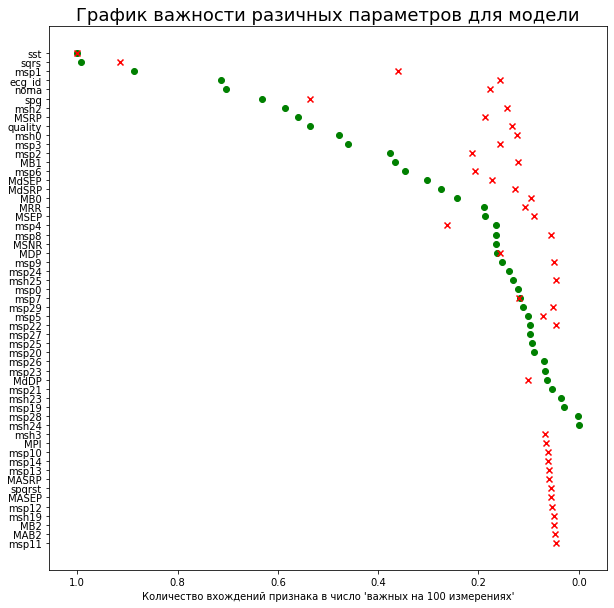

In [36]:
fig = plt.figure(figsize=[10, 10])

plt.scatter(order_values, order_columns, color = 'green')
plt.scatter(catboost_values[:i], catboost_columns[:i], color = 'red', marker = 'x')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

#plt.xticks(np.arange(21) * 5)
#plt.xlim(105, 20)

plt.title("График важности разичных параметров для модели", fontsize=18)
plt.xlabel("Количество вхождений признака в число 'важных на 100 измерениях'")

#plt.savefig("Images/Feature_importance_new_comparison.png")

plt.show()

Выберем столбцы, которые оставим

In [87]:
valuable_columns = order_columns
values_of_columns = order_values * 100

In [88]:
kept_columns = valuable_columns[values_of_columns >= 0]
kept_values = values_of_columns[values_of_columns >= 0]

In [89]:
train_kept = pd.DataFrame.copy(train_dataset.loc[:, kept_columns])
test_kept = pd.DataFrame.copy(test_dataset.loc[:, kept_columns])

In [90]:
kept_columns

Index(['sst', 'sqrs', 'msp1', 'ecg_id', 'noma', 'spq', 'msh2', 'MSRP',
       'quality', 'msh0', 'msp3', 'msp2', 'MB1', 'msp6', 'MdSEP', 'MdSRP',
       'MB0', 'MRR', 'MSEP', 'msp4', 'msp8', 'MSNR', 'MDP', 'msp9', 'msp24',
       'msh25', 'msp0', 'msp7', 'msp29', 'msp5', 'msp22', 'msp27', 'msp25',
       'msp20', 'msp26', 'msp23', 'MdDP', 'msp21', 'msh23', 'msp19', 'msp28',
       'msh24'],
      dtype='object')

In [91]:
kept_values

array([100.        ,  99.33439714,  88.7478035 ,  71.27798006,
        70.41812985,  63.07054194,  58.49700405,  56.00773683,
        53.6716483 ,  47.74767826,  45.91677169,  37.54674669,
        36.58957144,  34.59798092,  30.23271079,  27.55675723,
        24.28001719,  18.8652587 ,  18.69249777,  16.5966281 ,
        16.59253365,  16.52839766,  16.35374704,  15.36350514,
        13.97902721,  13.05391705,  12.07038243,  11.63300382,
        11.13980939,  10.10565149,   9.71277148,   9.63888229,
         9.40518688,   8.94942385,   6.83481997,   6.75353755,
         6.43155404,   5.36547911,   3.52423745,   3.02000571,
         0.21803095,   0.        ])

## Введем преобразование к матрице попарных расстояний:

In [92]:
def numeric_features(feat_line):
    
    pre_arr = np.absolute(feat_line[None, :] - feat_line[:, None])
    max_val = pre_arr.max()
    
    return pre_arr / pre_arr.max()

def build_distances(train_line, test_line):
    
    train_pre_arr = np.absolute(train_line[None, :] - train_line[:, None])
    test_pre_arr = np.absolute(train_line[None, :] - test_line[:, None])
    
    train_max = train_pre_arr.max()

    return train_pre_arr / train_max, test_pre_arr / train_max

def recombinate(arr_list, names_list):
    # also uses features and percentiles lists
    
    pairwise = np.zeros(arr_list[0].shape)
    
    for enum, item in enumerate(names_list):
        
        position = np.where(features == item)[0][0]
        pairwise += percentiles[position] / 100 * arr_list[enum]
        
    return pairwise

In [93]:
def recombination(train_df, test_df,
                  features, percentiles,
                  filling_diag = 'mean', 
                  using_percentiles = True):
    # пока что уберем из рассмотрения столбец Number, т.к. я не знаю, что с ним делать
    
    columns = train_df.columns
    #print(columns)
    
    train_len = train_df.__len__()
    test_len = test_df.__len__()
    
    train_pairwise = np.zeros((train_len, train_len))
    test_pairwise = np.zeros((test_len, train_len))
    
    for col in columns:
        
        train_arr = np.array(train_df[col])
        test_arr = np.array(test_df[col])
        
        train_dist, test_dist = build_distances(train_arr, test_arr)
        
        #print(np.where(features == col))
        #print(col)
        
        position = np.where(features == col)[0][0]
        
        if using_percentiles:
        
            train_pairwise += percentiles[position] / 100 * train_dist
            test_pairwise += percentiles[position] / 100 * test_dist

        else:
            
            train_pairwise += train_dist
            test_pairwise += test_dist
            
    if filling_diag == 'mean':
        
        np.fill_diagonal(train_pairwise, np.mean(train_pairwise))
        
    if filling_diag == 'median':
        
        np.fill_diagonal(train_pairwise, np.median(train_pairwise))
        
    if filling_diag == 'max':
        
        np.fill_diagonal(train_pairwise, np.max(train_pairwise))
        
    return train_pairwise, test_pairwise

## As a benchmark, i'll use just boosting:

In [94]:
values_1 = []
values_2 = []
values_3 = []
values_4 = []
values_5 = []
values_6 = []
values_7 = []
iters = [100, 200, 300, 400, 500,
         600, 700, 800, 900, 1000]
         #1500, 2000, 2500, 3000, 4000, 5000, 6000]

In [95]:
train_dataset.head(2)

,noma,ecg_id,MB0,MB1,MB2,MSEP,MSRP,MDP,MRR,MdSEP,...,msh22,msh23,msh24,msh25,msh26,msh27,msh28,msh29,msh30,msh31
0,61,46522,254,179,349,292,378,545,720,716,...,6.660123,5.549093,6.618528,5.510096,6.582642,5.501579,6.556057,5.493603,6.540355,5.468881
1,90,46886,197,144,303,224,382,488,790,788,...,6.726418,5.660824,6.682837,5.641838,6.650321,5.628031,6.628800,5.622539,6.617181,5.617567


In [96]:
train_normalized = (train_dataset - train_dataset.mean()) / train_dataset.std()
test_normalized = (test_dataset - test_dataset.mean()) / test_dataset.std()

In [97]:
train_p_pair, test_p_pair = recombination(train_kept,
                                          test_kept,
                                          valuable_columns,
                                          values_of_columns,
                                          filling_diag = 'mean',
                                          using_percentiles = True)

In [98]:
for it in iters:
    
    model = CatBoostClassifier(logging_level = "Silent",
                               iterations = it)
    
    model.fit(train_dataset, train_target)
    preds_1 = model.predict_proba(test_dataset)[:, 1]    
    values_1.append(roc_auc_score(test_target, preds_1))
    
    model.fit(train_normalized, train_target)
    preds_2 = model.predict_proba(test_normalized)[:, 1]    
    values_2.append(roc_auc_score(test_target, preds_2))
    
    model.fit(train_p_pair, train_target)
    preds_6 = model.predict_proba(test_p_pair)[:, 1]
    values_6.append(roc_auc_score(test_target, preds_6))
    
    """
            
    model.fit(train_f_pair, train_target)
    preds_4 = model.predict_proba(test_f_pair)[:, 1]    
    values_4.append(roc_auc_score(test_target, preds_4))
    
        
    model.fit(train_kept, train_target)
    preds_7 = model.predict_proba(test_kept)[:, 1]    
    values_7.append(roc_auc_score(test_target, preds_7))
    
    model.fit(kept_norm, train_target)
    preds_3 = model.predict_proba(kept_test_norm)[:, 1]    
    values_3.append(roc_auc_score(test_target, preds_3))

    model.fit(train_pair, train_target)
    preds_5 = model.predict_proba(test_pair)[:, 1]    
    values_5.append(roc_auc_score(test_target, preds_5))
    
    """

    print(it)

100
200
300
400
500
600
700
800
900
1000


In [99]:
import matplotlib.pyplot as plt

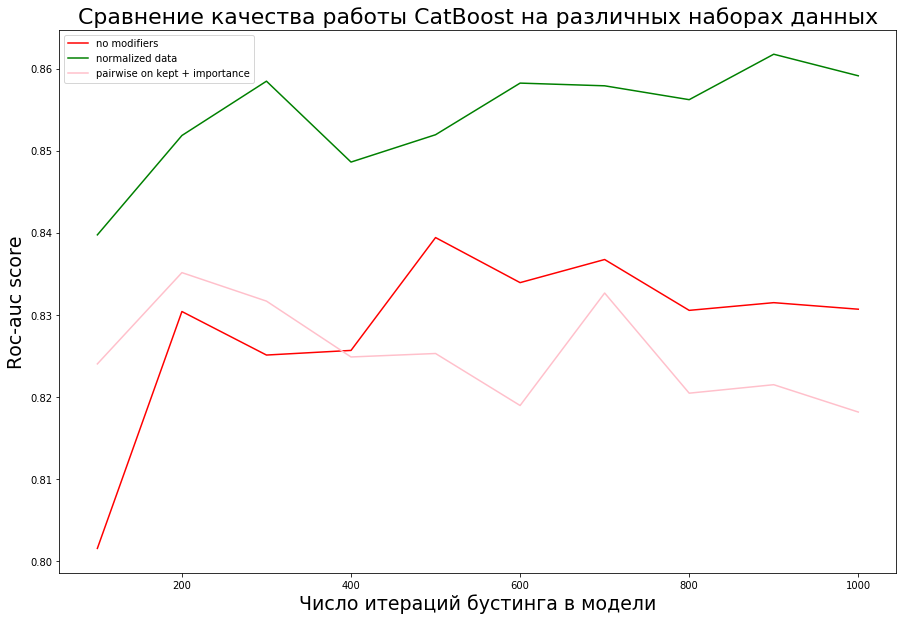

In [100]:
plt.figure(figsize = [15, 10])

plt.plot(iters, values_1, color = 'red', label = 'no modifiers' )
plt.plot(iters, values_2, color = 'green', label = 'normalized data')
#plt.plot(iters, values_3, color = 'blue', label = 'kept features + normalized')
#plt.plot(iters, values_4, color = 'purple', label = 'pairwise on initial data')
#plt.plot(iters, values_5, color = 'yellow', label = 'pairwise on kept data')
plt.plot(iters, values_6, color = 'pink', label = 'pairwise on kept + importance')
#plt.plot(iters, values_7, color = 'teal', label = 'kept features')
plt.legend()

plt.title("Сравнение качества работы CatBoost на различных наборах данных", fontsize=22)
plt.xlabel("Число итераций бустинга в модели", fontsize=19)
plt.ylabel("Roc-auc score", fontsize=19)

plt.savefig("Images/3st_catboost_3.png")

plt.show()

## Как видно, отбор параметров не сильно помогает работе catboost, т.к. в нем встроен собственный подбор параметров (результаты которого схожи с полученными мною)

Попробуем применить какую-нибудь другую популярную модель - randomforest

from sklearn.ensemble import RandomForestClassifier

model_forest = RandomForestClassifier()

values_10 = []
values_20 = []
values_30 = []
values_40 = []
values_50 = []
values_60 = []
values_70 = []

values_30 = []
values_50 = []
values_60 = []

for it in iters:
    
    model = RandomForestClassifier(n_estimators=it, n_jobs= -1)
    
    
    model.fit(train_dataset, train_target)
    preds_1 = model.predict_proba(test_dataset)[:, 1]    
    values_10.append(roc_auc_score(test_target, preds_1))
    
    model.fit(train_normalized, train_target)
    preds_2 = model.predict_proba(test_normalized)[:, 1]    
    values_20.append(roc_auc_score(test_target, preds_2))
    
    model.fit(train_p_pair, train_target)
    preds_6 = model.predict_proba(test_p_pair)[:, 1]
    values_60.append(roc_auc_score(test_target, preds_6))
    
    """
    
    model.fit(train_kept, train_target)
    preds_7 = model.predict_proba(test_kept)[:, 1]    
    values_70.append(roc_auc_score(test_target, preds_7))
    
    model.fit(train_f_pair, train_target)
    preds_4 = model.predict_proba(test_f_pair)[:, 1]    
    values_40.append(roc_auc_score(test_target, preds_4))

    model.fit(kept_norm, train_target)
    preds_3 = model.predict_proba(kept_test_norm)[:, 1]    
    values_30.append(roc_auc_score(test_target, preds_3))
    

    model.fit(train_pair, train_target)
    preds_5 = model.predict_proba(test_pair)[:, 1]    
    values_50.append(roc_auc_score(test_target, preds_5))
    

    """    
    print(it)

plt.figure(figsize = [15, 10])

plt.plot(iters, values_10, color = 'red', label = 'no modifiers' )
plt.plot(iters, values_20, color = 'green', label = 'normalized data')
#plt.plot(iters, values_30, color = 'blue', label = 'kept features + normalized')
#lt.plot(iters, values_40, color = 'purple', label = 'pairwise on initial data')
#plt.plot(iters, values_50, color = 'yellow', label = 'pairwise on kept data')
plt.plot(iters, values_60, color = 'pink', label = 'pairwise on kept + importance')
#plt.plot(iters, values_70, color = 'teal', label = 'kept features')
plt.legend()

plt.title("Сравнение качества работы RandomForest на различных наборах данных", fontsize=22)
plt.xlabel("Число деревьев в модели", fontsize=19)
plt.ylabel("Roc-auc score", fontsize=19)

#plt.savefig("Images/4st_forest_2.png")

plt.show()

мда


## попробуем ещё применить lgbm

In [101]:
from lightgbm import LGBMClassifier

In [102]:
values_100 = []
values_200 = []
values_300 = []
values_400 = []
values_500 = []
values_600 = []
values_700 = []

In [103]:
for it in iters:
    
    model = LGBMClassifier(n_estimators=it, n_jobs= - 1)

    model.fit(train_dataset, train_target)
    preds_1 = model.predict_proba(test_dataset)[:, 1]    
    values_100.append(roc_auc_score(test_target, preds_1))
    
    model.fit(train_normalized, train_target)
    preds_2 = model.predict_proba(test_normalized)[:, 1]    
    values_200.append(roc_auc_score(test_target, preds_2))
    
    model.fit(train_p_pair, train_target)
    preds_6 = model.predict_proba(test_p_pair)[:, 1]
    values_600.append(roc_auc_score(test_target, preds_6))
    
    """    
    model.fit(train_kept, train_target)
    preds_7 = model.predict_proba(test_kept)[:, 1]    
    values_700.append(roc_auc_score(test_target, preds_7))
    
    model.fit(train_f_pair, train_target)
    preds_4 = model.predict_proba(test_f_pair)[:, 1]    
    values_400.append(roc_auc_score(test_target, preds_4))
    
    model.fit(kept_norm, train_target)
    preds_3 = model.predict_proba(kept_test_norm)[:, 1]    
    values_300.append(roc_auc_score(test_target, preds_3))
    

    model.fit(train_pair, train_target)
    preds_5 = model.predict_proba(test_pair)[:, 1]    
    values_500.append(roc_auc_score(test_target, preds_5))
    """
    

    
    print(it)

100
200
300
400
500
600
700
800
900
1000


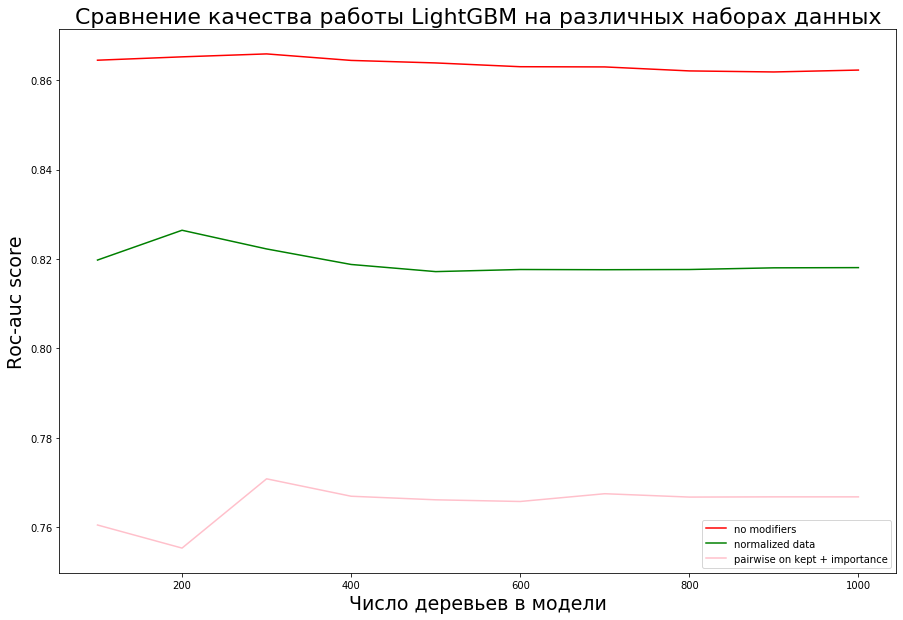

In [104]:
plt.figure(figsize = [15, 10])

plt.plot(iters, values_100, color = 'red', label = 'no modifiers' )
plt.plot(iters, values_200, color = 'green', label = 'normalized data')
#plt.plot(iters, values_300, color = 'blue', label = 'kept features + normalized')
#plt.plot(iters, values_400, color = 'purple', label = 'pairwise on initial data')
#plt.plot(iters, values_500, color = 'yellow', label = 'pairwise on kept data')
plt.plot(iters, values_600, color = 'pink', label = 'pairwise on kept + importance')
#plt.plot(iters, values_700, color = 'teal', label = 'kept features')
plt.legend()

plt.title("Сравнение качества работы LightGBM на различных наборах данных", fontsize=22)
plt.xlabel("Число деревьев в модели", fontsize=19)
plt.ylabel("Roc-auc score", fontsize=19)

plt.savefig("Images/3st_lgbm_3.png")

plt.show()